In [77]:
import pandas as pd
from binance.client import Client
import asyncio
from binance import AsyncClient, BinanceSocketManager
import nest_asyncio
nest_asyncio.apply()
from sqlalchemy import create_engine
from keys import bkey, secret
import numpy as np 
import ta
import datetime as dt
from tqdm import tqdm

In [94]:
client = Client(bkey,secret,tld='us')
engine = create_engine('sqlite:///backtest_usd_twomonths.db')

In [95]:
info = client.get_exchange_info()
symbols = [x['symbol'] for x in info['symbols']]
exclude = ['UP','DOWN','BEAR','BULL']
non_lev = [symbol for symbol in symbols if all(excludes not in symbol for excludes in exclude)]
relevant = [symbol for symbol in non_lev if symbol.endswith('USD')]

In [96]:
def getminutedataWithManip(symbol,lookback):
    df= pd.DataFrame(client.get_historical_klines(symbol,'1m',lookback+ ' days ago UTC'))
    
    df= df.iloc[:,:5]
    df.columns = ['Time','Open','High','Low','Close']
    df[['Open','High','Low','Close']] = df[['Open','High','Low','Close']].astype(float)
    df.Time = pd.to_datetime(df.Time,unit='ms')
    df['EMA200'] = ta.trend.ema_indicator(df.Close,window=200)
    df['wf_Top_bool'] = np.where(
    df['High']==df['High'].rolling(9,center=True).max(),True,False)
    df['wf_top'] = np.where(
    df['High']==df['High'].rolling(9,center=True).max(),df['High'],None
    )
    df['wf_top'] = df['wf_top'].ffill()
    df.dropna(inplace=True)
    df['Buy'] = np.where((df.Close> df.wf_top) & (df.Close>df.EMA200),1,0)
    df['SL'] = np.where(df.Buy==1, df.Close-(df.Close-df.Low),0)
    df['TP'] = np.where(df.Buy==1, df.Close+(df.Close-df.Low)*1.5,0)
    return df

In [97]:
for coin in tqdm(relevant):
    try:
        getminutedataWithManip(coin,'60').to_sql(coin,engine,index=False,if_exists='replace')
    except:
        pass

100%|████████████████████████████████████████| 82/82 [1:20:25<00:00, 58.85s/it]


In [92]:
def min_check(row):
    row['minute']=dt.datetime.fromtimestamp(dt.datetime.timestamp(row['Time'])).time().minute
    return  row
def returnCalc(profit,invest):
    for i in profit:
        change = 1+i
        fee = (invest*0.00075)
        invest = (change*invest)-fee
    return invest
def profits(df):
    buys, sells = [],[]
    for i in range(len(df)):
        if df.Buy.iloc[i]:
            buys.append(df.iloc[i].name)
            for j in range(len(df)-i):
                if df.TP.iloc[i] < df.Close.iloc[i+j] or \
                df.SL.iloc[i] > df.Close.iloc[i+j]:
                    sells.append(df.iloc[i+j].name)
                    break
    frame = pd.DataFrame([buys,sells]).T.dropna()
    frame.columns = ['Buys','Sells']
    actualtrades = frame[frame.Buys>frame.Sells.shift(1)]
    profits = (df.loc[actualtrades.Sells].Close.values - \
    df.loc[actualtrades.Buys].Close.values) / df.loc[actualtrades.Buys].Close.values
    return profits
def check_strat(stonks,invest=1000):
    res = {'ticker':[],'final_profit':[],'base_pcnt_change':[],'gain':[]}
    for i in stonks:
        try:
            df = pd.read_sql(i,engine)
            #df = df.apply(lambda row: min_check(row), axis=1)
            #df = df[df['minute']%interval==0]
            res['ticker'].append(i)
            base = df.copy()
            profit = profits(df)
            rets = returnCalc(profit,invest)
            res['final_profit'].append(rets)
            res['gain'].append(((rets-invest)/invest))
            res['base_pcnt_change'].append(list((base.Close.pct_change()+1).cumprod())[-1])
        except:
            pass
    #print(res)
    df=pd.DataFrame(res)
    return df
#ints = [1,15,30,45,60]
ints = [1]
for i in tqdm(ints):
    final = check_strat(relevant,1000)
    final['base_pcnt_change'] = final['base_pcnt_change'] -1
    final['win_delta'] = final['gain'] - final['base_pcnt_change']
    final.set_index('ticker', inplace=True)
    final.sort_values('final_profit', ascending=False,inplace=True)
    final.to_sql(str(i)+': analysis',engine,index=True,if_exists='replace')

100%|████████████████████████████████████████████| 1/1 [00:03<00:00,  3.36s/it]


In [113]:
sum(final.final_profit.head(5))-5000


240.68043296717406

In [115]:
(240/5000)*100

4.8

df = pd.read_sql(tc[0],engine)

In [ ]:
len(profits)

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

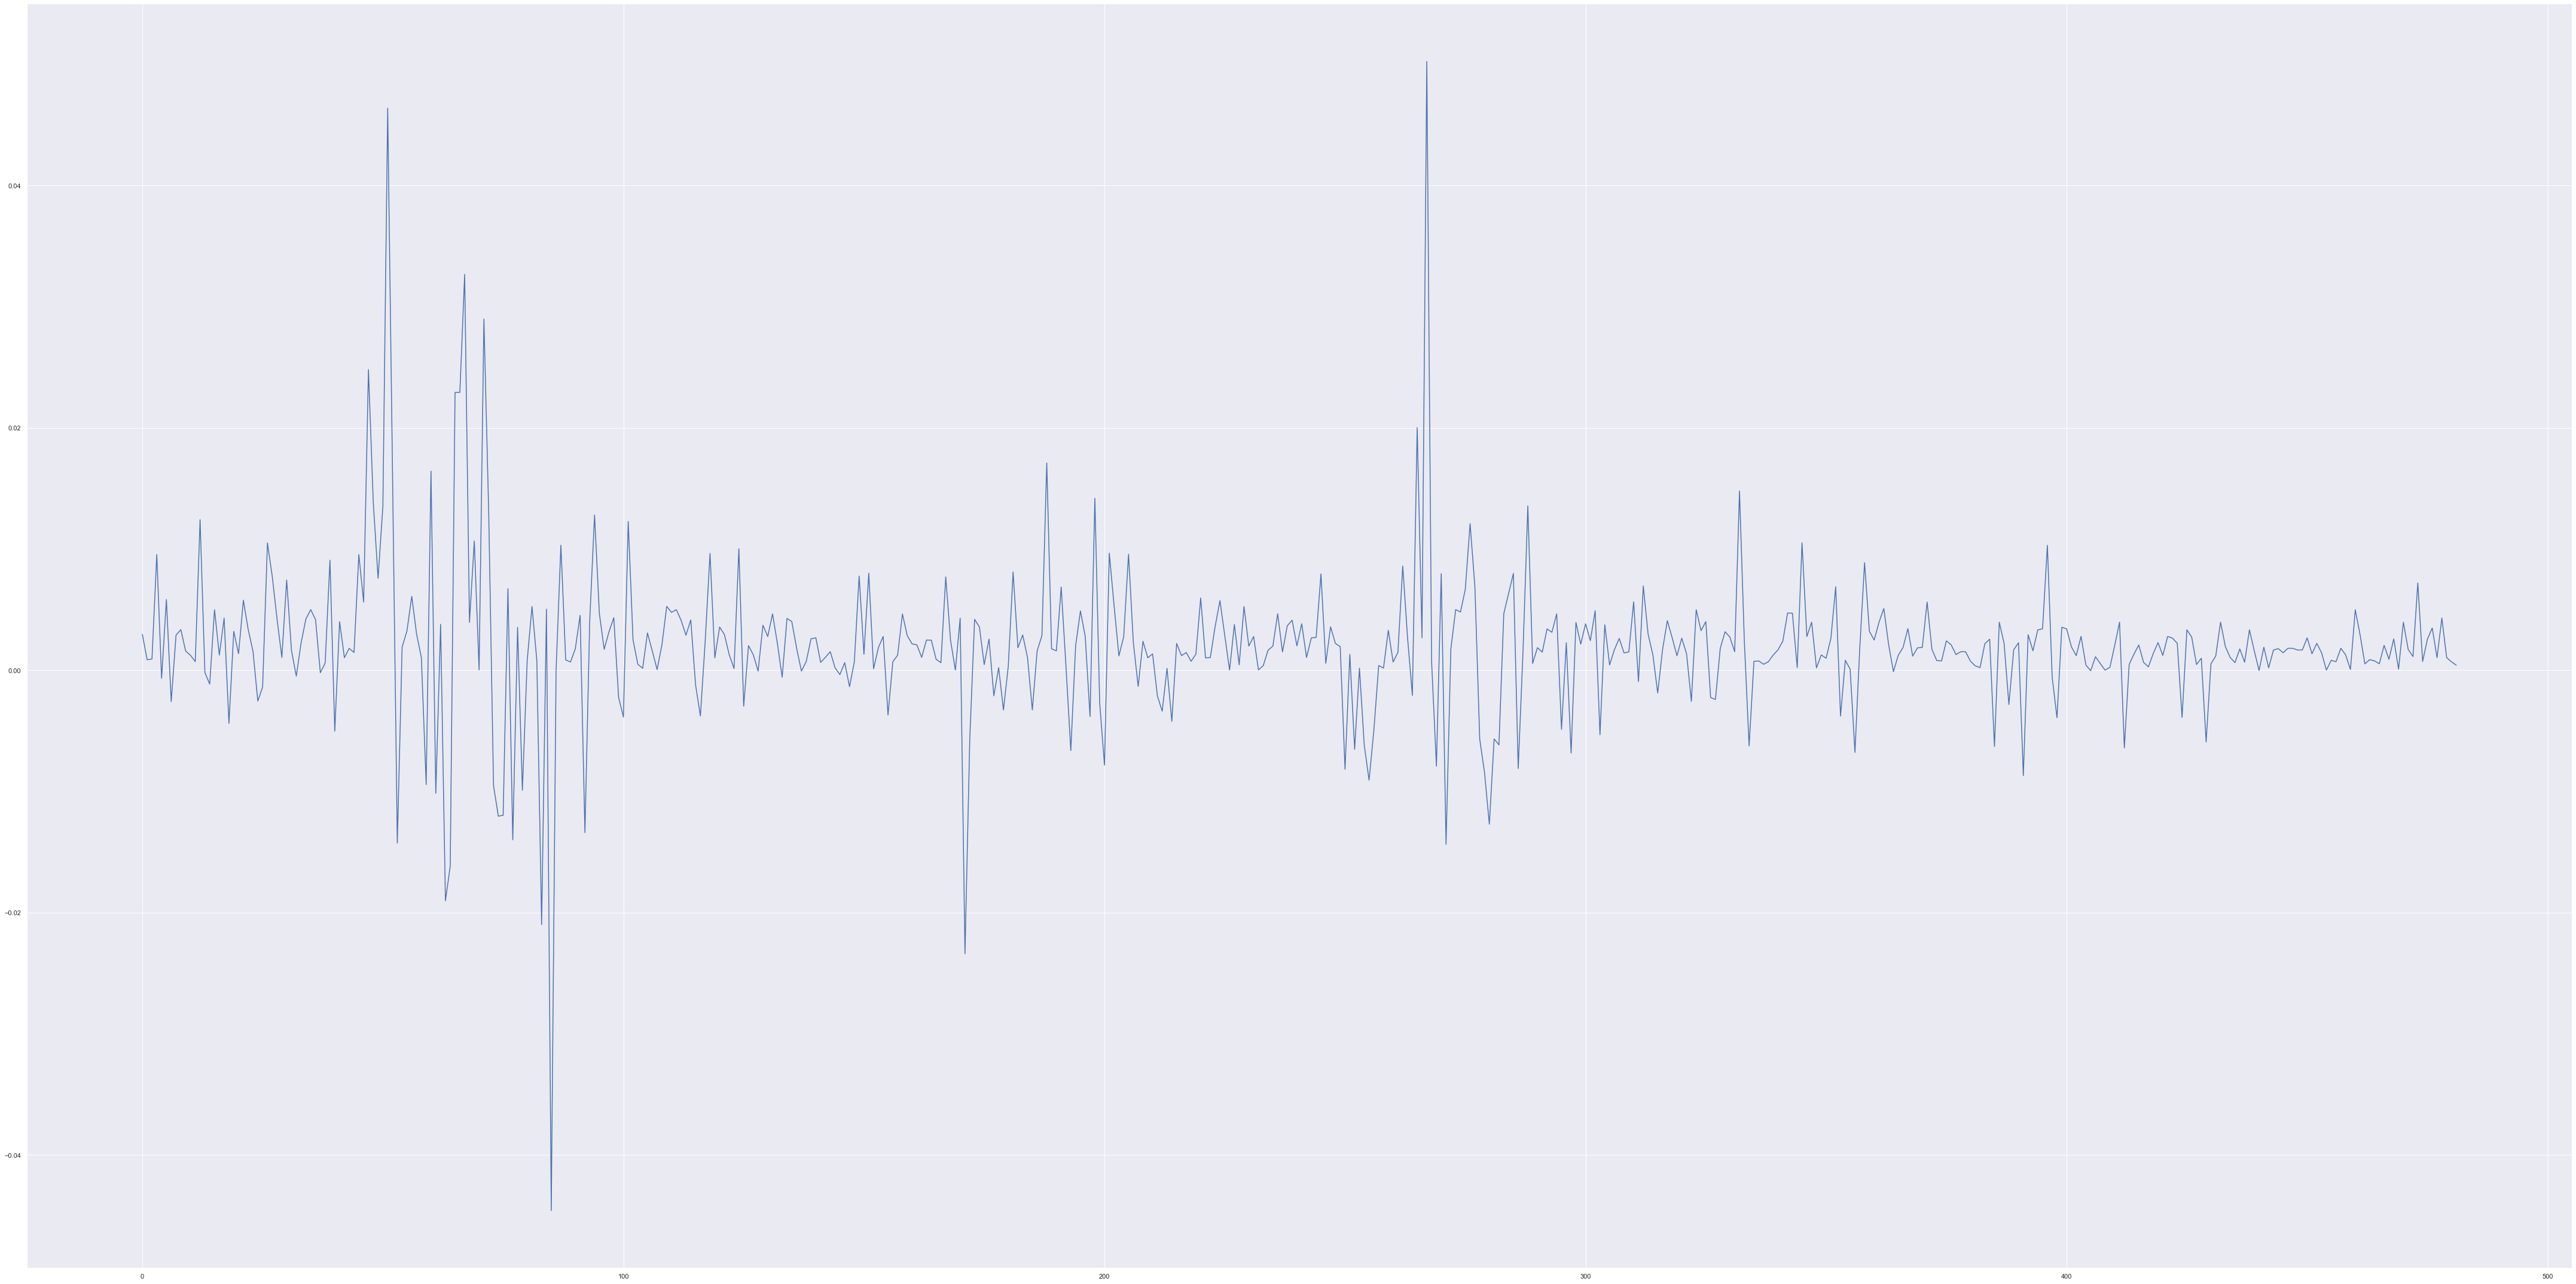

In [56]:
x= np.arange(0,len(profits(df)))
y = profits(df)
#fix,ax = plt.subplots(figsize=(15,20))

sns.relplot(x=x,y=y,kind='line',aspect=2,height=30)
#plt.show()

In [73]:
buys, sells = [],[]
for i in range(len(df)):
    if df.Buy.iloc[i]:
        buys.append(df.iloc[i].name)
        for j in range(len(df)-i):
            if df.TP.iloc[i] < df.Close.iloc[i+j] or \
            df.SL.iloc[i] > df.Close.iloc[i+j]:
                sells.append(df.iloc[i+j].name)
                break
frame = pd.DataFrame([buys,sells]).T.dropna()
frame.columns = ['Buys','Sells']
actualtrades = frame[frame.Buys>frame.Sells.shift(1)]
profits = (df.loc[actualtrades.Sells].Close.values - \
df.loc[actualtrades.Buys].Close.values) / df.loc[actualtrades.Buys].Close.values

IndentationError: unexpected indent (<ipython-input-73-a278bbdd3449>, line 2)

In [65]:
p=[]
invest = 1000
for i in profits(df):
        change = 1+i
        fee = (invest*0.00075)
        invest = (change*invest)-fee
        p.append(invest)
df2 = pd.DataFrame(p,columns={'investment'})


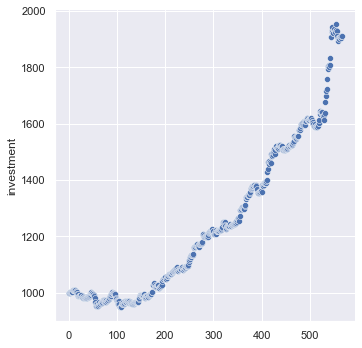

In [67]:
df2
sns.relplot(data=df2,
           x=df2.index,y=df2.investment)

In [71]:
df.to_excel('out.xlsx')